In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')

import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu
import shapely
from tqdm import tqdm, tqdm_notebook
import ast, shutil

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchshow as ts
from DataSetImagePresence import DataSetImagePresence
import loadpaths_pecl
path_dict_pecl = loadpaths_pecl.loadpaths()

Font size is set to 10


In [2]:
model_name_full = 'PECL-ImEn_2024-10-01-1358_vnum-64.data'
# model_path_checkpoint = '/home/tplas/models/PECL/lightning_logs/version_64/checkpoints/best_checkpoint_val-epoch=15-val_loss=4.31-train_loss=3.81.ckpt'

In [3]:
## Load dataset

filepath_train_val_split = os.path.join(path_dict_pecl['repo'], 'content/split_indices_s2bms_2024-08-14-1459.pth')
image_folder=None
presence_csv=None
batch_size=64
n_cpus=4
dataset_name = 's2bms'

image_folder = path_dict_pecl[f'{dataset_name}_images']
presence_csv = path_dict_pecl[f'{dataset_name}_presence']
ds = DataSetImagePresence(image_folder=image_folder, presence_csv=presence_csv,
                            shuffle_order_data=True, species_process='all',
                            augment_image=True, dataset_name=dataset_name,
                            zscore_im=True, mode='train')
train_ds, val_ds, test_ds = ds.split_into_train_val(filepath=filepath_train_val_split)
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=n_cpus, 
                        shuffle=True, persistent_workers=True, #drop_last=True, pin_memory=True
                        pin_memory=False, prefetch_factor=2)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=n_cpus, 
                    shuffle=False,  persistent_workers=True,
                    pin_memory=False) 
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=n_cpus, 
                        shuffle=False,  persistent_workers=True)
print(len(train_ds), len(val_ds), len(test_ds))

Found 1329 out of 1455 images in the image folder.
Shuffling data.
947 196 186


/home/tplas/repos/PECL/notebooks/../scripts/DataSetImagePresence.py:387: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_indices = torch.load(filepath)


In [4]:
## Load model

load_model_method = 'from_full_model' # 'from_checkpoint' or 'from_full_model', 'from_imagenet', 'from_scratch'
if load_model_method == 'from_full_model':
    model = pem.load_model(filename=model_name_full, verbose=0)
elif load_model_method == 'from_imagenet':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet='imagenet')
elif load_model_method == 'from_seco':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet='seco')
elif load_model_method == 'from_scratch':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet=False)
else:
    raise ValueError('Not implemented')

model.eval()

/home/tplas/anaconda3/envs/pecl2/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/tpla

ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [66]:
batch = next(iter(val_dl))
im, pres_vec = batch
print(im.shape, pres_vec.shape)

im_enc = model(im)
print(im_enc.shape)

def cosine_sim(a, b):
    return F.cosine_similarity(a, b, dim=-1)

def cosine_sim_self(a):
    assert len(a.shape) == 2
    n_samples, n_features = a.shape
    ## get cosine sim between all pairs of vectors
    a_norm = F.normalize(a, p=2, dim=1)
    sim = torch.mm(a_norm, a_norm.t())
    assert sim.shape == (n_samples, n_samples)
    return sim

sim_im_enc = cosine_sim_self(im_enc)
sim_presence = cosine_sim_self(pres_vec)
assert sim_im_enc.shape == sim_presence.shape, (sim_im_enc.shape, sim_presence.shape)

sim_im_enc = sim_im_enc.cpu().detach().numpy()
sim_presence = sim_presence.cpu().detach().numpy()

torch.Size([64, 4, 224, 224]) torch.Size([64, 62])
torch.Size([64, 256])


Text(0.5, 1.0, 'Correlation coefficient: 0.14')

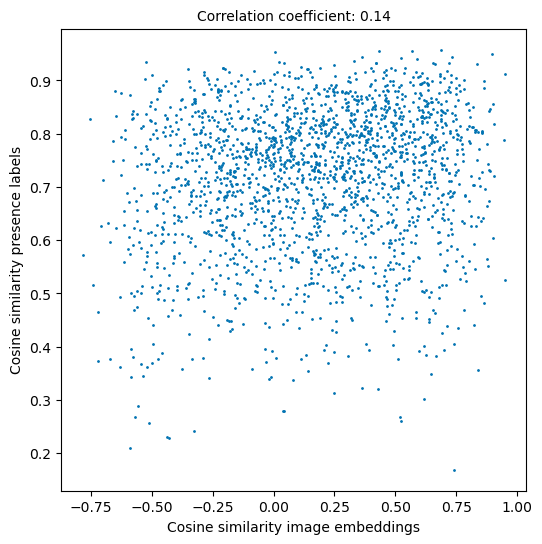

In [6]:
# ts.show(sim_im_enc), ts.show(sim_presence)
## scatter plot upper triangle of similarity matrices
n_samples = sim_im_enc.shape[0]
sim_im_enc = sim_im_enc[np.triu_indices(n_samples, k=1)]
sim_presence = sim_presence[np.triu_indices(n_samples, k=1)]
assert sim_im_enc.shape == sim_presence.shape

plt.figure(figsize=(6,6))
plt.scatter(sim_im_enc, sim_presence, s=1)
plt.xlabel('Cosine similarity image embeddings')
plt.ylabel('Cosine similarity presence labels')
corr_coef = np.corrcoef(sim_im_enc, sim_presence)[0,1]
plt.title(f'Correlation coefficient: {corr_coef:.2f}')

In [57]:
flatten_dist = False 
temperature = 1.0
pecl_knn = 1
pecl_knn_hard_labels = False


dist_array_ims = pem.normalised_softmax_distance_batch(im_enc, flatten=flatten_dist, temperature=temperature)
dist_array_pres = pem.normalised_softmax_distance_batch(pres_vec, flatten=flatten_dist, knn=pecl_knn,
                                                    knn_hard_labels=pecl_knn_hard_labels,
                                                    temperature=temperature,
                                                    similarity_function='cosine',
                                                    soft_weights_squared=True,  # only matters if hard labels is False
                                                    inner_prod_only=True)

tmp = dist_array_pres                                                    
inds_one = torch.where(dist_array_pres > 0)
if True:
    dist_array_pres = dist_array_pres[inds_one]
    assert (dist_array_pres > 0).any(), (dist_array_pres, im_enc.shape, pres_vec.shape, dist_array_ims.shape, dist_array_ims)

    dist_array_ims = dist_array_ims[inds_one]
    assert (dist_array_ims >= 0).all(), (dist_array_ims, im_enc)
    assert (dist_array_ims <= 1.01).all(), (dist_array_ims, im_enc)
    assert (dist_array_pres >= 0).all(), (dist_array_pres, im_enc, pres_vec)
    assert (dist_array_pres <= 1.01).all(), (dist_array_pres, pres_vec, torch.where(dist_array_pres > 1), dist_array_pres[torch.where(dist_array_pres > 1)])  # changed to 1.01 because of numerical issues when vals = 1.000
    loss = (-1 * torch.log(dist_array_ims + 1e-8) * dist_array_pres).mean()
    assert loss >= 0, loss

In [60]:
dist_array_ims

tensor([0.0120, 0.0196, 0.0217, 0.0210, 0.0195, 0.0229, 0.0259, 0.0221, 0.0178,
        0.0157, 0.0134, 0.0133, 0.0078, 0.0125, 0.0377, 0.0201, 0.0223, 0.0116,
        0.0244, 0.0321, 0.0228, 0.0216, 0.0213, 0.0115, 0.0105, 0.0198, 0.0075,
        0.0142, 0.0109, 0.0212, 0.0080, 0.0171, 0.0227, 0.0238, 0.0245, 0.0101,
        0.0185, 0.0166, 0.0176, 0.0222, 0.0237, 0.0204, 0.0285, 0.0212, 0.0150,
        0.0196, 0.0186, 0.0222, 0.0104, 0.0152, 0.0304, 0.0099, 0.0273, 0.0356,
        0.0071, 0.0227, 0.0123, 0.0195, 0.0264, 0.0088, 0.0170, 0.0128, 0.0144,
        0.0112], grad_fn=<IndexBackward0>)

In [81]:
inds_one

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 tensor([27,  3, 29,  1, 25,  2, 31, 40, 15,  4, 61,  0, 21, 23, 53,  8, 52, 40,
         20,  9, 18, 57, 24, 15, 49,  8, 63, 15, 45,  2, 63, 15, 22,  8, 47, 22,
          3, 55,  1, 54,  7, 47, 50, 55, 15, 29,  3, 41, 55,  2, 42, 54, 16, 14,
         51, 43, 36, 21,  8, 57,  5, 10, 23, 30]))

In [52]:
# inds_one
dist_array_pres

tensor([0.7456, 0.8845, 0.8715, 0.8845, 0.8707, 0.8693, 0.8092, 0.9172, 0.9134,
        0.8564, 0.8390, 0.7346, 0.5520, 0.7088, 0.7849, 0.9134, 0.8878, 0.6517,
        0.8044, 0.7763, 0.8044, 0.7755, 0.7890, 0.8513, 0.8091, 0.8911, 0.6594,
        0.9081, 0.8131, 0.8715, 0.6750, 0.8694, 0.7144, 0.8921, 0.7814, 0.7051,
        0.8646, 0.8261, 0.8440, 0.8168, 0.9172, 0.9129, 0.9025, 0.8656, 0.8497,
        0.8374, 0.8287, 0.9129, 0.8116, 0.8534, 0.9025, 0.8742, 0.8878, 0.7849,
        0.8742, 0.8656, 0.7401, 0.7755, 0.8106, 0.4862, 0.8388, 0.8390, 0.6679,
        0.6750])

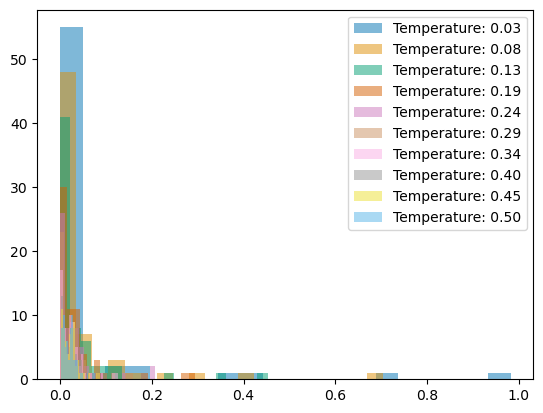

In [90]:
def create_softmax_distance_matrix(
    temperature = 0.3):
    inner = torch.tensor(sim_im_enc)
    inner = torch.exp(inner / temperature)
    sum_inner = torch.sum(inner, dim=1)
    diag = torch.diag(inner)
    sum_inner = sum_inner - diag
    sum_inner = sum_inner + 1e-8
    inner = inner / sum_inner[:, None]

    return inner[inds_one]

## plot hist as func of temp
n_temps = 10
temperatures = np.linspace(0.03, 0.5, n_temps)

for temp in temperatures:
    dist_array_ims = create_softmax_distance_matrix(temperature=temp)
    plt.hist(dist_array_ims, bins=20, alpha=0.5, label=f'Temperature: {temp:.2f}')
plt.legend()


In [51]:
torch.topk(dist_array_pres - torch.diag(dist_array_pres.diag()), k=2, largest=True, sorted=False, dim=1)[1]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

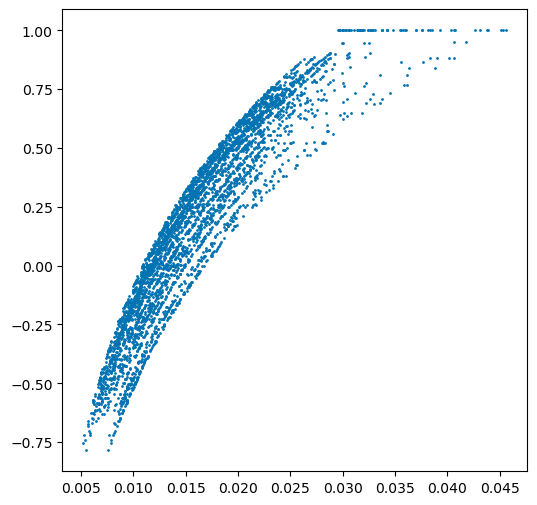

In [31]:
# dist_array_ims = dist_array_ims.cpu().detach().numpy()

plt.figure(figsize=(6,6))
# plt.scatter(dist_array_ims, dist_array_pres, s=1)
plt.scatter(dist_array_ims, sim_im_enc, s=1)

tensor([1, 5, 7, 3, 1, 4, 0, 2, 6, 5, 3, 1, 0, 0, 2, 5, 2, 1, 4, 1, 2, 2, 2, 2,
        1, 3, 1, 4, 1, 2, 1, 3, 0, 5, 1, 1, 3, 1, 0, 2, 2, 2, 2, 2, 0, 1, 0, 4,
        1, 6, 2, 1, 1, 1, 2, 4, 0, 2, 1, 0, 1, 1, 0, 2])


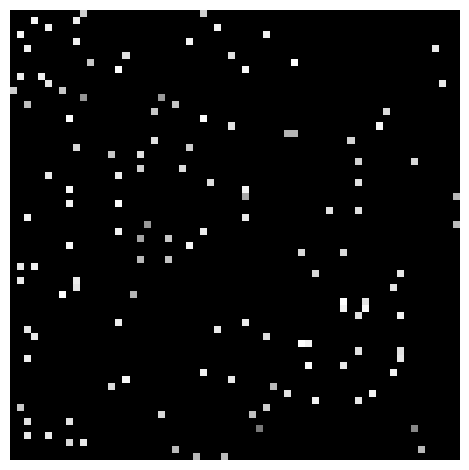

In [21]:
ts.show(dist_array_pres)
print(torch.sum(dist_array_pres > 0, 0))  ## 2 per row

In [12]:
dist_array_ims 

tensor([[0.0328, 0.0215, 0.0166,  ..., 0.0110, 0.0144, 0.0107],
        [0.0194, 0.0295, 0.0217,  ..., 0.0140, 0.0182, 0.0076],
        [0.0155, 0.0225, 0.0306,  ..., 0.0179, 0.0208, 0.0068],
        ...,
        [0.0115, 0.0163, 0.0199,  ..., 0.0342, 0.0176, 0.0107],
        [0.0143, 0.0201, 0.0222,  ..., 0.0168, 0.0327, 0.0104],
        [0.0148, 0.0116, 0.0101,  ..., 0.0142, 0.0144, 0.0453]],
       grad_fn=<DivBackward0>)